Fetching house price data from EJ56...


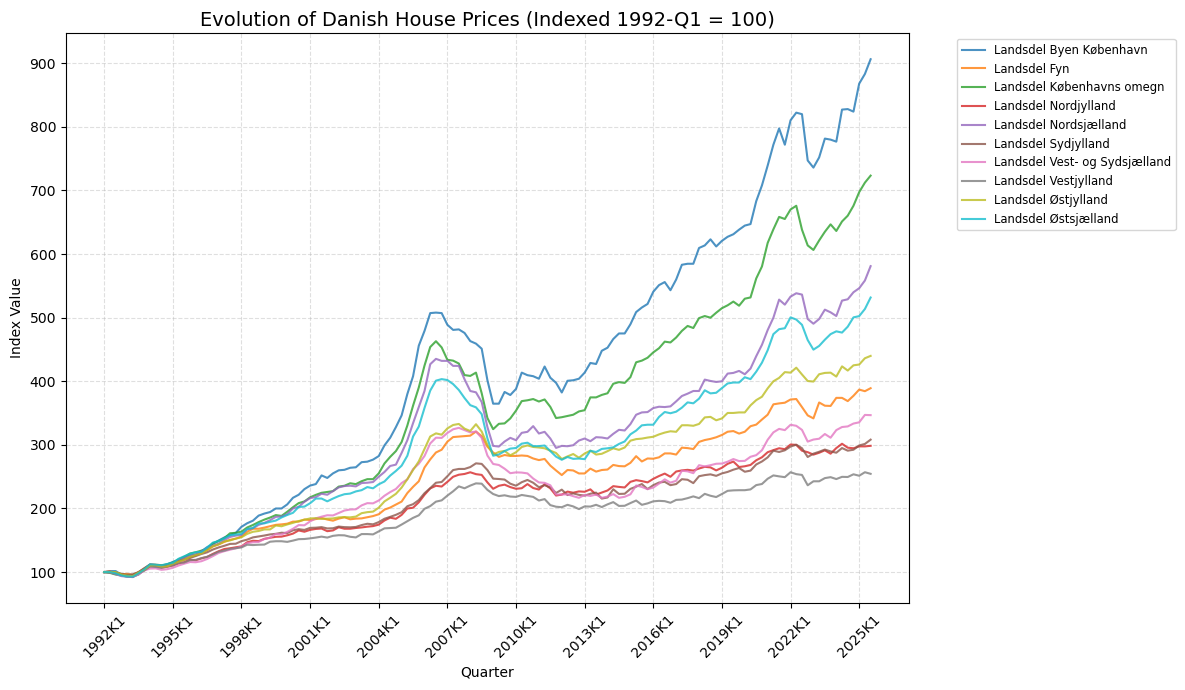


Ranking of Provinces by Total House Price Growth (Since 1992-Q1):
-----------------------------------------------------------------
OMRÅDE
Landsdel Byen København          806.40
Landsdel Københavns omegn        623.38
Landsdel Nordsjælland            481.05
Landsdel Østsjælland             431.71
Landsdel Østjylland              339.92
Landsdel Fyn                     289.13
Landsdel Vest- og Sydsjælland    246.77
Landsdel Sydjylland              208.21
Landsdel Nordjylland             198.53
Landsdel Vestjylland             154.50
Name: 2025K3, dtype: float64


In [ ]:
# Subsection 1.1 - Nominal House Price Evolution (Indexed)

import pandas as pd
import requests
import io
import matplotlib.pyplot as plt

# 1. Get the API Codes
def get_metadata_codes():
    
    # The API uses specific internal codes (IDs) for variables like 'One-family houses'.
    # We ask the API for these codes first, so we don't get errors by guessing.

    meta_url = "https://api.statbank.dk/v1/tableinfo/EJ56?lang=en"
    r = requests.get(meta_url)
    r.raise_for_status()
    meta = r.json()
    
    codes = {}
    
    # Find the variable for Property Category (for example, 'EJENDOMSKATE')
    cat_var = next(v for v in meta['variables'] if 'EJENDOM' in v['id'].upper())
    codes['cat_var_id'] = cat_var['id']
    
    # Find the code for 'One-family houses' inside that variable
    cat_val = next(val for val in cat_var['values'] if 'FAMILY' in val['text'].upper() or 'ENFAMILIE' in val['text'].upper())
    codes['cat_val_id'] = cat_val['id']
    
    # Find the variable for Unit (for example, 'TAL')
    unit_var = next(v for v in meta['variables'] if v['id'] in ['TAL', 'ENHED'])
    codes['unit_var_id'] = unit_var['id']
    
    # Find the code for 'Index' inside that variable
    unit_val = next(val for val in unit_var['values'] if 'INDEX' in val['text'].upper() or 'INDEKS' in val['text'].upper())
    codes['unit_val_id'] = unit_val['id']
    
    return codes


# 2. Download the Data
def fetch_ej56_data():
    # Get the codes
    codes = get_metadata_codes()
    
    url = "https://api.statbank.dk/v1/data"

    # Build the request package
    payload = {
        "table": "EJ56",
        "format": "CSV",
        "variables": [
            {"code": "OMRÅDE", "values": ["*"]},               # Get all areas
            {"code": codes['cat_var_id'], "values": [codes['cat_val_id']]}, # Specific house type
            {"code": codes['unit_var_id'], "values": [codes['unit_val_id']]}, # Specific unit (Index)
            {"code": "Tid", "values": ["*"]}                   # All time periods
        ]
    }
    
    response = requests.post(url, json=payload)
    response.raise_for_status()
    
    # Return raw data
    return pd.read_csv(io.StringIO(response.text), sep=";")


# 3. Clean and prepare data
def process_house_prices(df_raw):
    # Fix numbers: Denmark uses commas for decimals, Python wants dots
    df_raw["Value"] = pd.to_numeric(df_raw["INDHOLD"].astype(str).str.replace(",", "."), errors="coerce")
    
    # Find the column that contains the area names
    cols_to_exclude = ["TID", "INDHOLD", "GL_TID", "Indhold", "EJENDOMSKATE", "TAL", "ENHED", "EJENDOMSKATEGORI"]
    area_col = next(c for c in df_raw.columns if c not in cols_to_exclude)
    
    # Flip the table: Dates as rows, areas as columns
    df = df_raw.pivot(index="TID", columns=area_col, values="Value")
    
    # Keep only the columns that have "Landsdel" (Provinces) in the name
    provinces = [c for c in df.columns if "Landsdel" in str(c)]
    df = df[provinces]
    
    # Keep data only from 1992-Q1 onwards
    df = df[df.index >= "1992K1"]
    
    # Remove any columns that have missing data (holes)
    df_clean = df.dropna(axis=1, how='any')
    
    # Re-index: Divide everyone by their first value (1992) and multiply by 100
    # This makes them all start at the same point so we can compare growth.
    base_values = df_clean.iloc[0]
    df_indexed = (df_clean / base_values) * 100
    
    return df_indexed


# 4. Plotting and ranking
def plot_and_rank(df_indexed):
    # Setup the plot size
    plt.figure(figsize=(12, 7))
    
    # Draw a line for each province
    for province in df_indexed.columns:
        plt.plot(df_indexed.index, df_indexed[province], label=province, linewidth=1.5, alpha=0.8)
    
    plt.title("Evolution of Danish House Prices (Indexed 1992-Q1 = 100)", fontsize=14)
    plt.ylabel("Index Value")
    plt.xlabel("Quarter")
    plt.xticks(df_indexed.index[::12], rotation=45)

    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

    # Calculate total growth (Last value - 100)
    total_growth = (df_indexed.iloc[-1] - 100).sort_values(ascending=False)
    
    print("\nRanking of Provinces by Total House Price Growth (Since 1992-Q1):")
    print("-" * 65)
    print(total_growth.round(2))
    return total_growth


# 5. Execution

if __name__ == "__main__":
    print("Fetching house price data from EJ56...")
    
    # Run the functions in order
    df_raw = fetch_ej56_data()
    final_data = process_house_prices(df_raw) 
    
    # Plot and rank
    plot_and_rank(final_data)

CONCLUSION:
The analysis highlights a major geographic divergence. Provinces near Copenhagen ('Landsdel Byen København', 'Københavns omegn') show 
exponential price growth compared to rural areas since 1992.

Calculating Real Prices using data from Question 1.1...


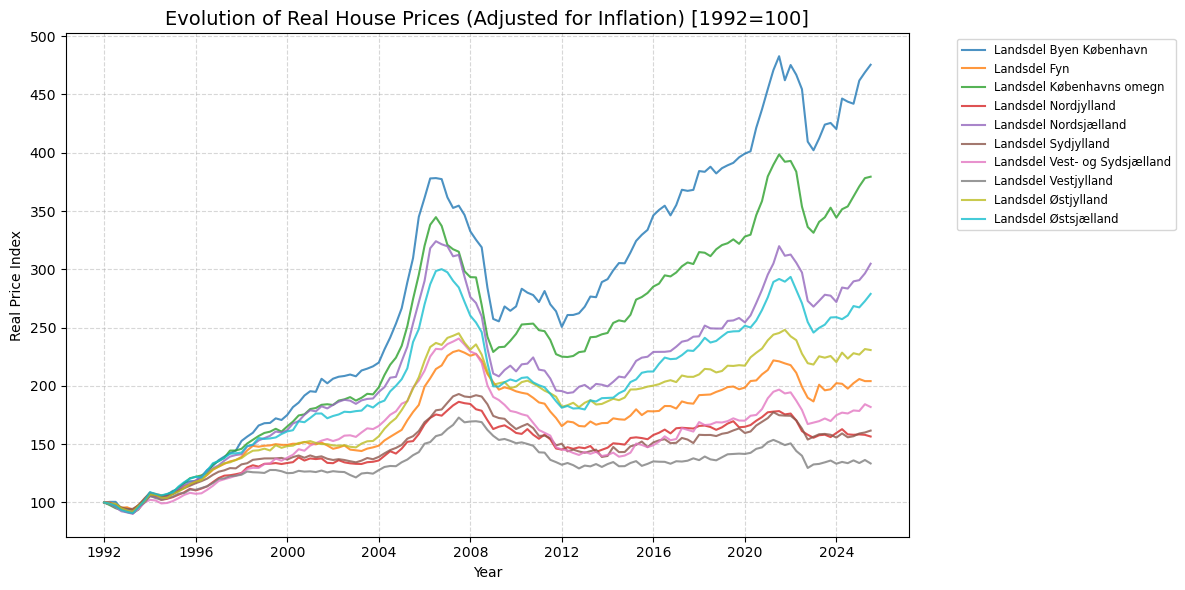


Ranking of Provinces by Total Real House Price Growth (Since 1992-Q1):
OMRÅDE
Landsdel Byen København          375.50
Landsdel Københavns omegn        279.49
Landsdel Nordsjælland            204.82
Landsdel Østsjælland             178.94
Landsdel Østjylland              130.78
Landsdel Fyn                     104.14
Landsdel Vest- og Sydsjælland     81.92
Landsdel Sydjylland               61.69
Landsdel Nordjylland              56.61
Landsdel Vestjylland              33.51
Name: 2025-07-01 00:00:00, dtype: float64


In [ ]:
# Subsection 1.2: Real House Price Evolution (Indexed)


# 1. Fetching the requred data
# First, we need a helper tool to get the inflation data (CPI).
def get_cpi_quarterly():

    url = "https://api.statbank.dk/v1/data"
    
    # Making a payload to the API asking for:
    # 1. Table PRIS113
    # 2. Variable TYPE = INDEKS (this gives us the index numbers)
    # 3. All time periods (Tid = *)
    payload = {
        "table": "PRIS113",
        "format": "CSV",
        "variables": [
            {"code": "TYPE", "values": ["INDEKS"]},  
            {"code": "Tid", "values": ["*"]}
        ]
    }
    
    # Send the payload and checking if it arrived
    r = requests.post(url, json=payload)
    r.raise_for_status()
    
    # Open the package and read it as a table
    df = pd.read_csv(io.StringIO(r.text), sep=";")
    
    # Fix the numbers since Denmark uses commas (,)
    df["CPI"] = pd.to_numeric(df["INDHOLD"].astype(str).str.replace(",", "."), errors="coerce")
    
    # Fix the dates: Turn "2022M01" into a real calendar date
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")
    
    # The inflation data comes every month.
    # Our house prices are every quarter.
    # To counter this, take the average of the months to get one number per quarter.
    return df.set_index("Date")["CPI"].resample("QS").mean()



# 2. Calculate and Plot

print("Calculating Real Prices using data from Question 1.1")

try:
    # Reuse the house price data we already cleaned in Question 1.1
    # We make a copy so we don't accidentally mess up the original.
    df_nominal = final_data.copy() 
    
    # Fix the dates in the house price data
    # Right now, they look like text: "1992K1".
    # We need to translate them into computer dates: "1992-01-01".
    # This allows us to match them with the inflation dates.
    df_nominal.index = pd.to_datetime([f"{x[:4]}-{int(x[5])*3-2:02d}-01" for x in df_nominal.index])

    # Get the inflation numbers (CPI) using our helper tool above
    df_cpi = get_cpi_quarterly()

    # Match the two datasets
    # We only want to keep the dates that exist in both lists.
    # (for example, if we have inflation for 2025 but no house prices yet, drop it).
    common_idx = df_nominal.index.intersection(df_cpi.index)
    df_nominal = df_nominal.loc[common_idx]
    cpi_series = df_cpi.loc[common_idx]

    # Calculate Real Prices
    # Formula: (House Price / Inflation Index) * 100
    df_real = df_nominal.div(cpi_series, axis=0) * 100

    # Reset the starting line
    # To compare fairly, we make everyone start at 100 in the first year (1992).
    df_real_indexed = (df_real / df_real.iloc[0]) * 100

    # Plot the chart
    plt.figure(figsize=(12, 6))
    for col in df_real_indexed.columns:
        plt.plot(df_real_indexed.index, df_real_indexed[col], label=col, linewidth=1.5, alpha=0.8)

    plt.title("Evolution of Real House Prices (Adjusted for Inflation) [1992=100]", fontsize=14)
    plt.ylabel("Real Price Index")
    plt.xlabel("Year")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True, linestyle="--", alpha=0.5) 
    plt.tight_layout() 
    plt.show()

    # Print the final ranking
    print("\nRanking of Provinces by Total Real House Price Growth (Since 1992-Q1):")
    print((df_real_indexed.iloc[-1] - 100).sort_values(ascending=False).round(2))

except Exception as e:
    pass

Processing Real Prices for Municipalities...
Correlation between Initial Level and Total Growth: 0.8135


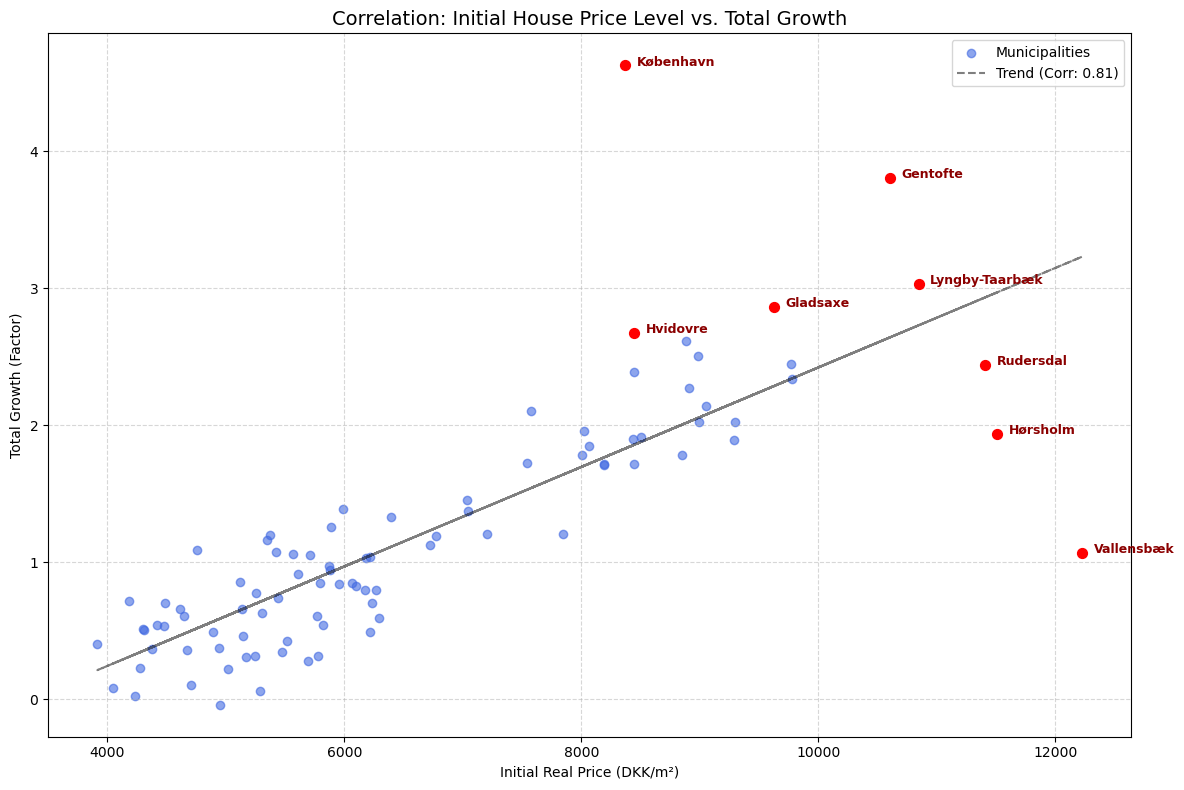

In [3]:
# Subsection 1.3: Real House Prices per m² (Municipalities)

import os
import numpy as np

# 1. Load Excel Data
def load_excel_data(filename="BM010_houses.xlsx"):
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd() 
    file_path = os.path.join(script_dir, filename)
    
    df = pd.read_excel(file_path, header=None)
    header_row = df.iloc[2].copy()
    header_row[2] = "Area"
    df.columns = header_row
    df = df.iloc[3:].copy()
    
    df["Area"] = df["Area"].astype(str).str.strip()
    df = df.set_index("Area")
    date_cols = [c for c in df.columns if isinstance(c, str) and "Q" in c]
    df = df[date_cols]
    
    date_map = {}
    for col in df.columns:
        year = int(col[:4])
        quarter = int(col[5])
        month = quarter * 3 - 2
        date_map[col] = pd.to_datetime(f"{year}-{month:02d}-01")
            
    df = df.rename(columns=date_map)
    return df.T.apply(pd.to_numeric, errors='coerce')

# 2. Fetch CPI Data
def get_cpi_data():
    url = "https://api.statbank.dk/v1/data"
    payload = {
        "table": "PRIS113",
        "format": "CSV",
        "variables": [{"code": "TYPE", "values": ["INDEKS"]}, {"code": "Tid", "values": ["*"]}]
    }
    r = requests.post(url, json=payload)
    df = pd.read_csv(io.StringIO(r.text), sep=";")
    df["CPI"] = pd.to_numeric(df["INDHOLD"].astype(str).str.replace(",", "."), errors="coerce")
    df["Date"] = pd.to_datetime(df["TID"], format="%YM%m")
    return df.set_index("Date")["CPI"].resample("QS").mean()


# 3. Execution

print("Processing Real Prices for Municipalities...")

# Create variables
df_muni_nominal = load_excel_data()
cpi = get_cpi_data() 

# Clean Data (Drop missing columns)
df_muni_clean = df_muni_nominal.dropna(axis=1, how='any')

# Align and calculate Real Prices
common_idx = df_muni_clean.index.intersection(cpi.index)
df_muni_clean = df_muni_clean.loc[common_idx]
cpi_aligned = cpi.loc[common_idx]

# Save as 'df_muni_real' (Important for Q1.4)
df_muni_real = df_muni_clean.div(cpi_aligned, axis=0) * 100

# Correlation Analysis
initial_level = df_muni_real.iloc[0]
latest_level = df_muni_real.iloc[-1]
total_growth = (latest_level - initial_level) / initial_level
correlation = initial_level.corr(total_growth)

print(f"Correlation between Initial Level and Total Growth: {correlation:.4f}")

# Identify Labels (Top 5 Growth + Top 5 Initial Level)
top_5_growth = total_growth.sort_values(ascending=False).head(5).index.tolist()
top_5_initial = initial_level.sort_values(ascending=False).head(5).index.tolist()

# Combine lists (remove duplicates)
labels_to_show = list(set(top_5_growth + top_5_initial))

# 4. Plotting
plt.figure(figsize=(12, 8))

# Scatter plot of ALL municipalities (Blue)
plt.scatter(initial_level, total_growth, alpha=0.6, color='royalblue', label='Municipalities')

# Highlight and Label the SPECIFIC ones requested (Red)
for area in labels_to_show:
    x_val = initial_level[area]
    y_val = total_growth[area]
    
    # Plot a red dot
    plt.scatter(x_val, y_val, color='red', s=50, zorder=5)
    
    # Add the text label slightly offset
    plt.text(x_val + 100, y_val, area, fontsize=9, color='darkred', weight='bold')

# Add trendline
z = np.polyfit(initial_level, total_growth, 1)
p = np.poly1d(z)
plt.plot(initial_level, p(initial_level), "k--", alpha=0.5, label=f"Trend (Corr: {correlation:.2f})")

plt.title("Correlation: Initial House Price Level vs. Total Growth", fontsize=14)
plt.xlabel("Initial Real Price (DKK/m²)")
plt.ylabel("Total Growth (Factor)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The correlation coefficient is approximately 0.81. This indicates a strong positive relationship.
Municipalities that had higher house prices in 1992 (the initial level) generally experienced much higher percentage growth over the
following decades compared to those that started with lower prices.

Analyzing recovery since the 2008 crisis...

Summary:
- Municipalities BELOW 2008 Peak: 83
- Municipalities ABOVE 2008 Peak: 9


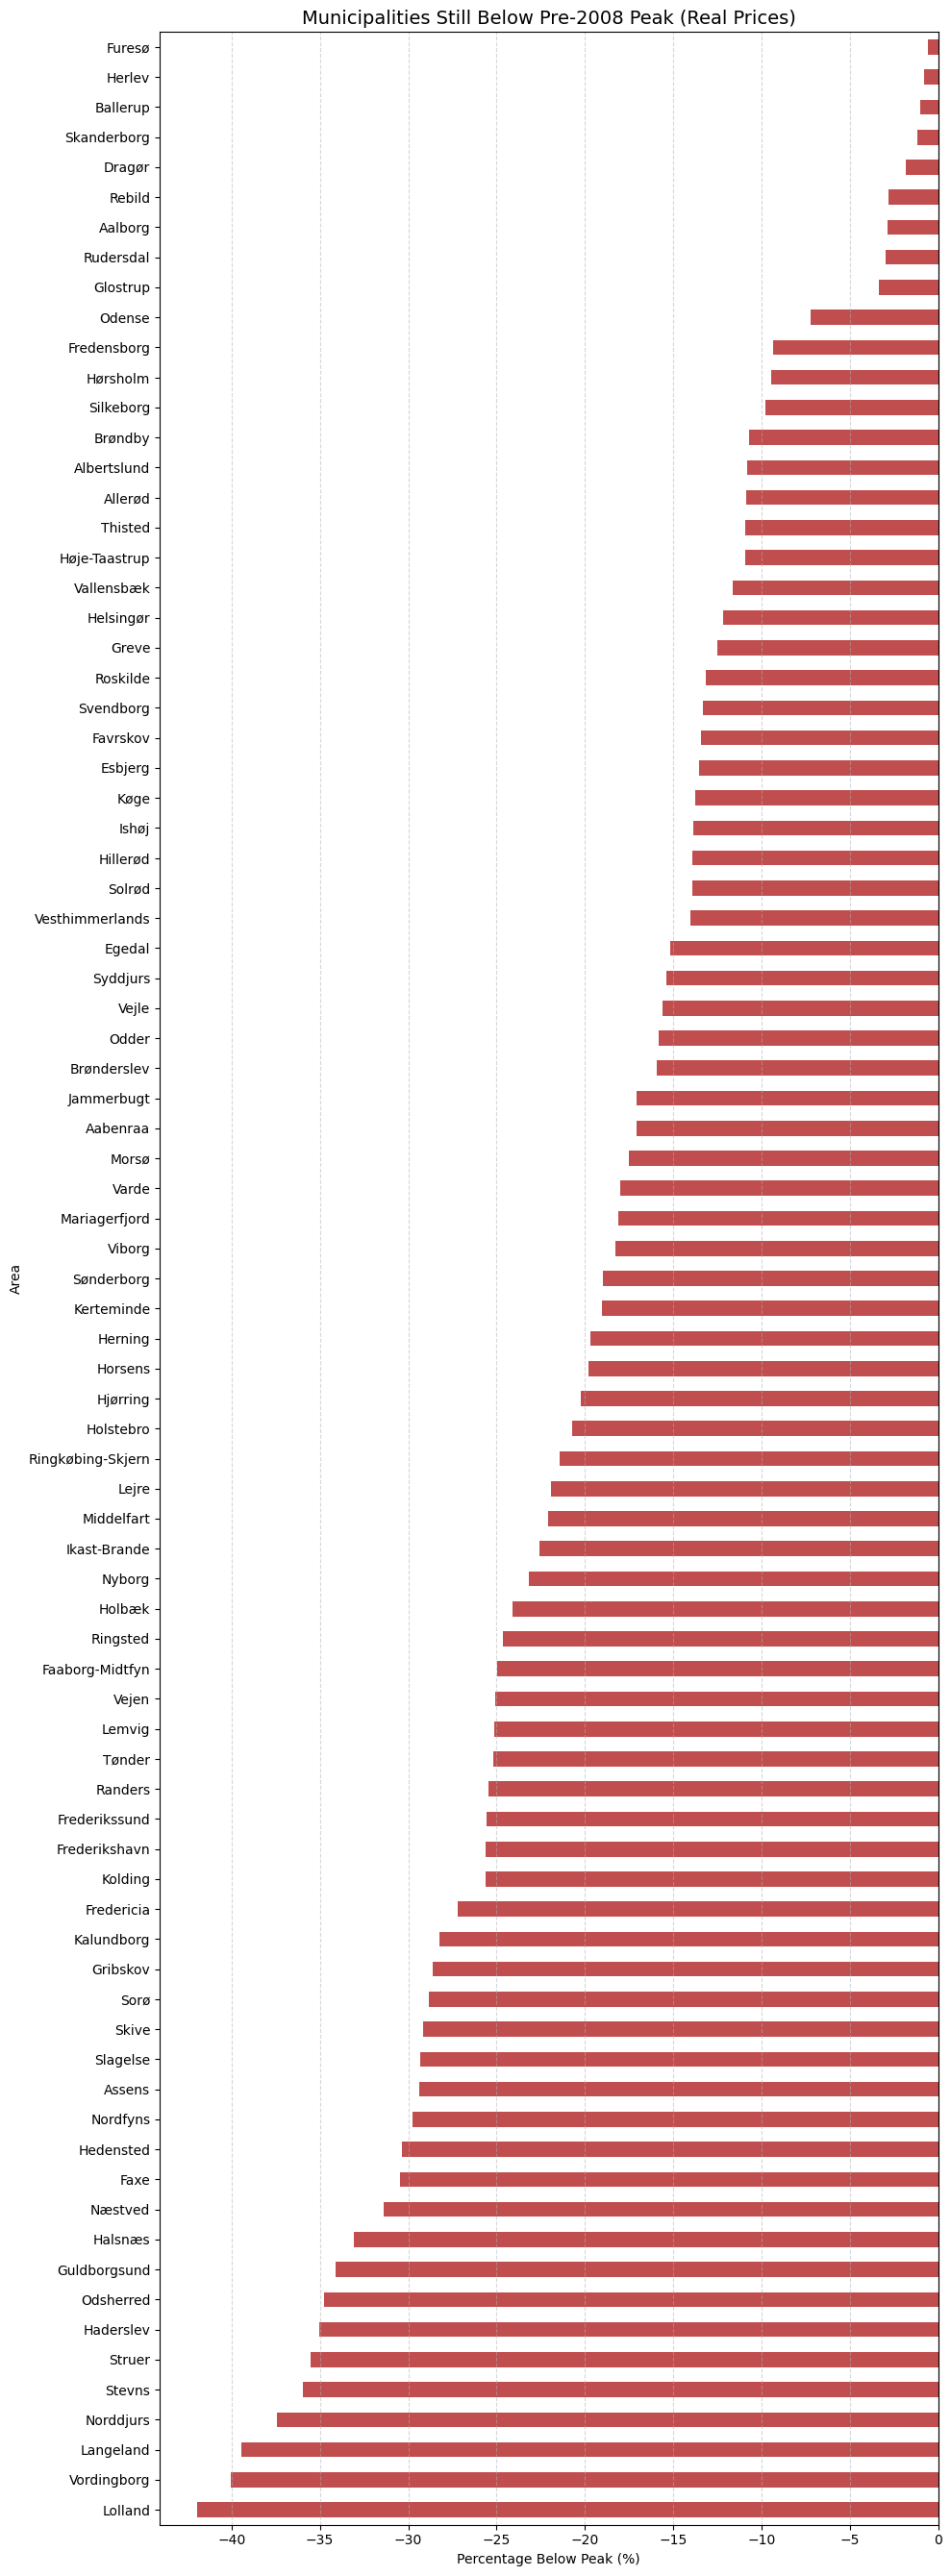


--- List: Municipalities BELOW Peak ---
Area
Lolland       -41.97
Vordingborg   -40.05
Langeland     -39.42
Norddjurs     -37.45
Stevns        -35.98
               ...  
Dragør         -1.82
Skanderborg    -1.16
Ballerup       -1.02
Herlev         -0.77
Furesø         -0.60
Length: 83, dtype: float64


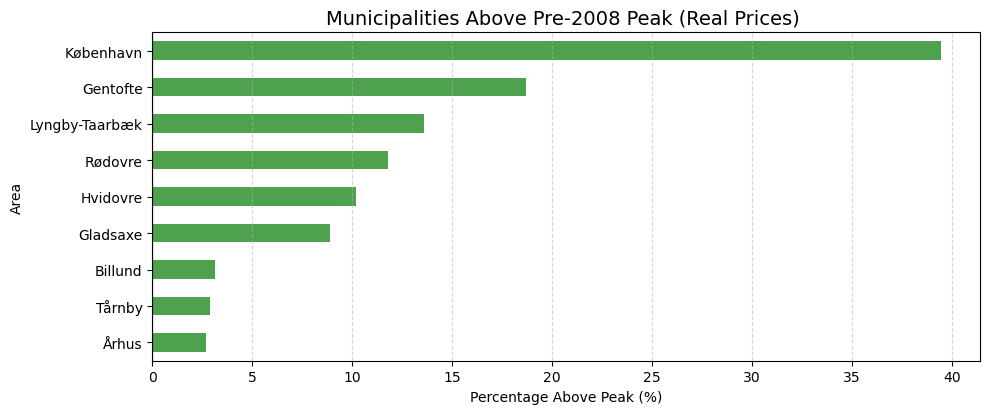


--- List: Municipalities ABOVE Peak (Top 10) ---
Area
København         39.44
Gentofte          18.72
Lyngby-Taarbæk    13.60
Rødovre           11.78
Hvidovre          10.17
Gladsaxe           8.89
Billund            3.16
Tårnby             2.87
Århus              2.67
dtype: float64


In [ ]:
# Subsection 1.4 - Recovery Analysis


# 1. Analyze the Recovery
print("Analyzing recovery since the 2008 crisis...")

# We grab the real prices we already calculated in Question 1.3
df = df_muni_real.copy()

# Smooth the data (4-Quarter Rolling Average)
# This removes short-term noise to reveal the true trend
df_rolling = df.rolling(window=4).mean()

# Find the "Pre-Crisis Peak"
# We look for the highest price each municipality reached before 2009
pre_crisis_data = df_rolling.loc[:'2008-12-31']
peaks = pre_crisis_data.max()

# Compare with today
# We take the very last available price in the dataset
latest_values = df_rolling.iloc[-1]

# Calculate the difference in percentage: (Today - Peak) / Peak
pct_diff = ((latest_values - peaks) / peaks) * 100

# Split the municipalities into two teams:
# Team 1: Still below their 2008 peak (Negative %)
below_peak = pct_diff[pct_diff < 0].sort_values()
# Team 2: Above their 2008 peak (Positive %)
above_peak = pct_diff[pct_diff >= 0].sort_values()

print(f"\nSummary:")
print(f"- Municipalities BELOW 2008 Peak: {len(below_peak)}")
print(f"- Municipalities ABOVE 2008 Peak: {len(above_peak)}")


# 2. Plotting

# Plot 1: The "Struggling" Areas (Below Peak)
if not below_peak.empty:
    # Adjust chart height based on how many areas are in the list
    plt.figure(figsize=(10, len(below_peak) * 0.3 + 2)) 
    below_peak.plot(kind='barh', color='firebrick', alpha=0.8)

    plt.title("Municipalities Still Below Pre-2008 Peak (Real Prices)", fontsize=14)
    plt.xlabel("Percentage Below Peak (%)")
    plt.axvline(0, color='black', linewidth=0.8) 
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- List: Municipalities BELOW Peak ---")
    print(below_peak.round(2))
else:
    print("\nNo municipalities are below their pre-2008 peak.")


# Plot 2: The "Recovered" Areas (Above Peak)
if not above_peak.empty:
    # Adjust chart height, but cap it so it doesn't get infinite
    height = min(len(above_peak) * 0.25 + 2, 25)
    plt.figure(figsize=(10, height)) 
    
    # If the list is huge, we just show the top 40 to keep it readable
    if len(above_peak) > 50:
        plot_data = above_peak.tail(40) 
        title_suffix = "(Top 40 Shown)"
    else:
        plot_data = above_peak
        title_suffix = ""

    plot_data.plot(kind='barh', color='forestgreen', alpha=0.8)

    plt.title(f"Municipalities Above Pre-2008 Peak (Real Prices) {title_suffix}", fontsize=14)
    plt.xlabel("Percentage Above Peak (%)")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- List: Municipalities ABOVE Peak (Top 10) ---")
    print(above_peak.sort_values(ascending=False).head(10).round(2))